In [1]:
from cloudvolume import CloudVolume
from caveclient import CAVEclient
import navis
from navis import TreeNeuron
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import time
from tqdm import tqdm
import json
import uuid  
from datetime import datetime
from scipy.spatial import ConvexHull
from sklearn.cluster import DBSCAN
from scipy.spatial import distance, distance_matrix, cKDTree
from scipy.sparse.csgraph import minimum_spanning_tree
import networkx as nx
import plotly.express as px
import plotly.graph_objects as go
import cloudvolume as cv

navis.patch_cloudvolume()

vol = cv.CloudVolume("precomputed://gs://zheng_mouse_hippocampus_production/v2/seg_m195", use_https=True, progress=False) # new from Will
seg = cv.CloudVolume("graphene://https://minnie.microns-daf.com/segmentation/table/zheng_ca3", use_https=True) # old

client = CAVEclient('zheng_ca3')
auth = client.auth

# CloudVolume and Cave setup
sv = CloudVolume('graphene://https://minnie.microns-daf.com/segmentation/table/zheng_ca3', use_https=True, lru_bytes=int(1e8))

INFO  : cloud-volume successfully patched! (navis)


In [2]:
client = CAVEclient('zheng_ca3')

In [9]:
def update_segids_df(df, super_voxel_col):
    # Get the current date
    current_date = datetime.now().strftime('%Y%m%d')  # Format: YYYYMMDD
    
    # Update segids
    updated_segid_list = client.chunkedgraph.get_roots(df[super_voxel_col])
    
    # Add the updated segids to the DataFrame with the date in the column name
    updated_col_name = f"updated_segids_{current_date}"
    df[updated_col_name] = updated_segid_list
    
    print(f"Number of updated segids: {len(df)}")
    return df, updated_segid_list, current_date

# -------- Distance Function (on scaled coords) --------
def euclidean_distance_scaled(coord1, coord2):
    return np.linalg.norm(np.array(coord1) - np.array(coord2))


# -------- Plot Function --------
def plot_nucleus_with_synapses(nucleus_pos, all_positions, radius=20):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    nucleus = np.array(nucleus_pos)
    all_positions = np.array(all_positions)

    ax.scatter(*nucleus, color='red', s=100, label='Nucleus Center')

    if len(all_positions) > 0:
        ax.scatter(all_positions[:, 0], all_positions[:, 1], all_positions[:, 2],
                   color='blue', alpha=0.6, s=20, label='pre_pt_positions')

    u, v = np.mgrid[0:2 * np.pi:40j, 0:np.pi:20j]
    x = radius * np.cos(u) * np.sin(v) + nucleus[0]
    y = radius * np.sin(u) * np.sin(v) + nucleus[1]
    z = radius * np.cos(v) + nucleus[2]
    ax.plot_surface(x, y, z, color='green', alpha=0.1, edgecolor='none')

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("Single Nucleus with Synapses and 20K Radius")
    ax.legend()
    plt.tight_layout()
    plt.show()

    
def process_all_rows(merged_df, graph_first=False):
    merged_df[['x', 'y', 'z', 'size_um3']] = merged_df[['x', 'y', 'z', 'size_um3']].astype(float)
    plot_done = False  # only plot once
    
    merged_df['pre_pt_root_id_list'] = None
    merged_df['pre_pt_supervoxel_id_list'] = None
    merged_df['pre_pt_position_list'] = None
    merged_df['num_perisomatic_syn'] = 0
    
    today = datetime.now().strftime("%Y%m%d")

    for idx in tqdm(merged_df.index, desc="Querying synapses and filtering"):
        post_id = merged_df.at[idx, f'updated_segids_{today}']
        nucleus_pos = [merged_df.at[idx, 'x'], merged_df.at[idx, 'y'], merged_df.at[idx, 'z']]
        volume = merged_df.at[idx, 'size_um3']

        # Calculate soma diameter from volume (assuming a sphere)
        radius_um = ((3 * volume) / (4 * np.pi)) ** (1/3)
        diameter_um = 2 * radius_um
        threshold = diameter_um + (0.10 * diameter_um)  # Use as filtering radius

        # Scale nucleus coords
        scaled_nucleus = [nucleus_pos[0]*0.018, nucleus_pos[1]*0.018, nucleus_pos[2]*0.045]

        try:
            df_synapses = client.materialize.synapse_query(
                pre_ids=None,
                post_ids=post_id,
                synapse_table="synapses_ca3_v1",
                desired_resolution=[18, 18, 45]
            )
        except Exception as e:
            print(f"Error querying synapses for {post_id}: {e}")
            continue

        if df_synapses.empty:
            print("No synapses found.")
            continue

        all_positions_raw = df_synapses['pre_pt_position'].tolist()
        all_positions_scaled = [[p[0]*0.018, p[1]*0.018, p[2]*0.045] for p in all_positions_raw]

        # Plot only once
        if not plot_done:
            if graph_first:
                plot_nucleus_with_synapses(scaled_nucleus, all_positions_scaled, radius=threshold)
            plot_done = True

        # Compute distances
        distances = [euclidean_distance_scaled(scaled_nucleus, p) for p in all_positions_scaled]
        filtered_indices = [i for i, d in enumerate(distances) if d <= threshold]

        # Save filtered data
        filtered_pre_ids = df_synapses.iloc[filtered_indices]['pre_pt_root_id'].tolist()
        filtered_supervoxels = df_synapses.iloc[filtered_indices]['pre_pt_supervoxel_id'].tolist()
        filtered_positions = [all_positions_raw[i] for i in filtered_indices]

        merged_df.at[idx, 'pre_pt_root_id_list'] = filtered_pre_ids
        merged_df.at[idx, 'pre_pt_supervoxel_id_list'] = filtered_supervoxels
        merged_df.at[idx, 'pre_pt_position_list'] = filtered_positions
        merged_df.at[idx, 'num_perisomatic_syn'] = len(filtered_pre_ids)

        convert_to_JSON(filtered_positions, post_id, id_name=post_id, print_output=False)
    
    merged_df.to_csv(f'Perisomatic_pyr_synapses_{today}.csv')

    return merged_df


def convert_to_JSON(pre_pt_positions, segid, id_name=None, print_output=False):
    """Save pre_pt_positions as Neuroglancer annotation points with timestamped filename."""

    json_path = "annotation_base_file.json"
    with open(json_path, "r") as f:
        neuroglancer_state = json.load(f)

    # Create DataFrame from the list of positions
    df = pd.DataFrame(pre_pt_positions, columns=['x', 'y', 'z'])

    # Scale XYZ
    xyz_data_scaled = [[x / 1, y / 1, z / 1] for x, y, z in df[['x', 'y', 'z']].values]

    # Add annotation points
    annotation_layer = next((layer for layer in neuroglancer_state["layers"] if layer["type"] == "annotation"), None)
    if annotation_layer:
        for xyz in xyz_data_scaled:
            annotation_layer["annotations"].append({"point": xyz, "type": "point", "id": str(uuid.uuid4())})

    # Add segment to segmentation layer
    seg_layer = next((layer for layer in neuroglancer_state["layers"]
                      if layer["type"] == "segmentation" and "segments" in layer and layer.get("name") == "zheng_ca3"), None)
    if seg_layer:
        seg_layer["segments"].append(str(segid))

    # Create output file name with current date
    current_date = datetime.now().strftime("%Y%m%d")
    id_suffix = f"_{id_name}" if id_name else ""
    output_path = f"{segid}_neuroglancer_annotations_{current_date}{id_suffix}.json"

    # Save JSON
    with open(output_path, "w") as f:
        json.dump(neuroglancer_state, f, indent=4)

    if print_output:
        print(f"Updated JSON saved to: {output_path}")
        
        
def merge_dfs(df_1, df_2):
    
    current_date = datetime.now().strftime('%Y%m%d')

    merged_df = pd.merge(
        df_1[[f'updated_segids_{current_date}', 'curve_distance']],
        df_2[[f'updated_segids_{current_date}', 'x', 'y', 'z', 'supervoxel', 'size_um3']],
        on=f'updated_segids_{current_date}',
        how='inner'
    )
    
    return merged_df

In [10]:
df_nuclei = pd.read_csv('nuclei_table_250217 - nuclei.csv', dtype={'segid_0217': str, 'supervoxel': str, 'x': str, 'y': str, 'z': str})
df_nuclei = df_nuclei.dropna(subset=['supervoxel'])
df_nuclei_updated, updated_segid_list_nuclei, current_date = update_segids_df(df_nuclei, super_voxel_col='supervoxel')

df_pyrs = pd.read_csv('all_pyramidal_cells - all_pyr_v2_remove_dupes.csv')
df_pyrs, _, _ = update_segids_df(df_pyrs, 'supervoxel')

merged_df = merge_dfs(df_pyrs, df_nuclei_updated)
merged_df = process_all_rows(merged_df, graph_first=False)

merge_df.head(5)

Number of updated segids: 1739
Number of updated segids: 1840


Querying synapses and filtering:   1%|      | 11/1531 [00:05<12:44,  1.99it/s]


KeyboardInterrupt: 

### Graphing Data

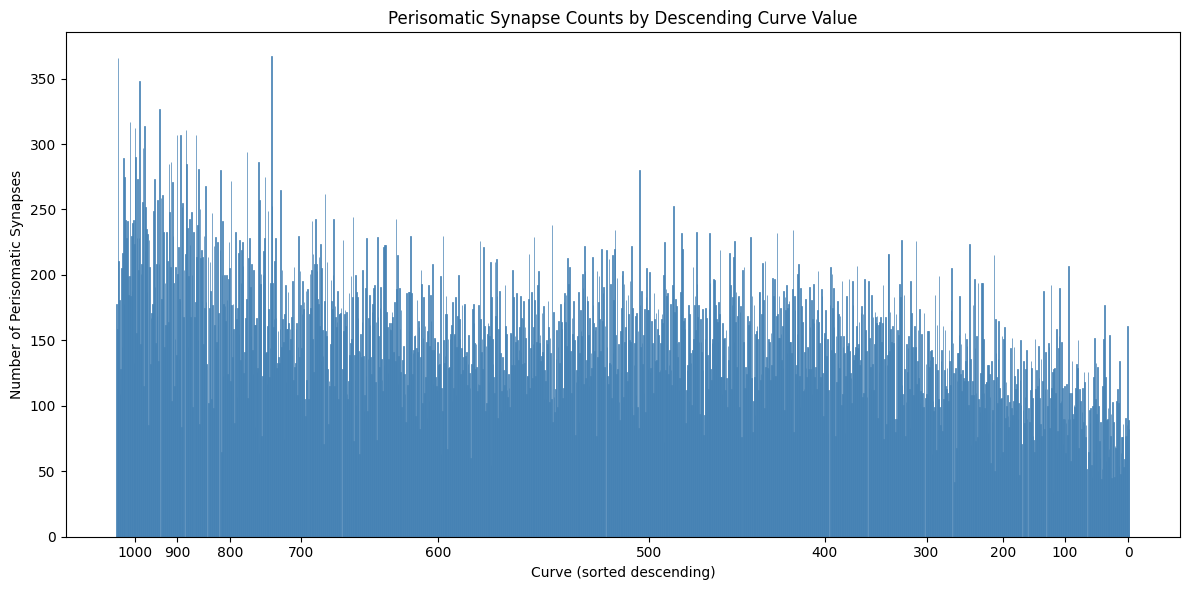

In [169]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------------------------------------------------------
# 1. Prepare and sort your data
# -----------------------------------------------------------------------------
df = merged_df  

# Drop rows where 'curve' is missing, if any
df = df.dropna(subset=['curve_distance'])

# Sort in descending order by 'curve' so largest is first (leftmost bar)
df_sorted = df.sort_values(by='curve_distance', ascending=False).reset_index(drop=True)
df = df[df['num_perisomatic_syn'] != 0]

# -----------------------------------------------------------------------------
# 2. Set up x positions as a simple integer range for uniform bar widths
# -----------------------------------------------------------------------------
x_positions = np.arange(len(df_sorted))  # [0, 1, 2, 3, ...]

# Extract the data to plot
y_values = df_sorted['num_perisomatic_syn'].values  # 🔁 CHANGED
curve_values = df_sorted['curve_distance'].values

# -----------------------------------------------------------------------------
# 3. Plot bars with uniform width
# -----------------------------------------------------------------------------
plt.figure(figsize=(12, 6))
plt.bar(x_positions, y_values, width=1, color='steelblue', edgecolor='steelblue', linewidth=0.5)
plt.xlabel('Curve (sorted descending)')
plt.ylabel('Number of Perisomatic Synapses')  # 🔁 CHANGED
plt.title('Perisomatic Synapse Counts by Descending Curve Value')  # 🔁 CHANGED

# -----------------------------------------------------------------------------
# 4. Create x-axis ticks for multiples of 100 (approximate curve scale)
# -----------------------------------------------------------------------------
max_curve = curve_values[0]  # largest curve (since we sorted descending)
min_curve = curve_values[-1] # smallest curve

# Round them to nearest hundreds
start = int(np.floor(max_curve / 100.0) * 100)
end   = int(np.floor(min_curve / 100.0) * 100)
if end < 0:
    end = 0

tick_values = np.arange(start, end - 1, -100)
tick_positions = []
tick_labels = []

for val in tick_values:
    idx_closest = np.argmin(np.abs(curve_values - val))
    tick_positions.append(idx_closest)
    tick_labels.append(str(val))

# Set tick marks
plt.xticks(tick_positions, tick_labels)
plt.savefig('Perisomatic_Synapse_Counts_by_Descending_Curve_Value.png', dpi=600)

plt.tight_layout()
plt.show()

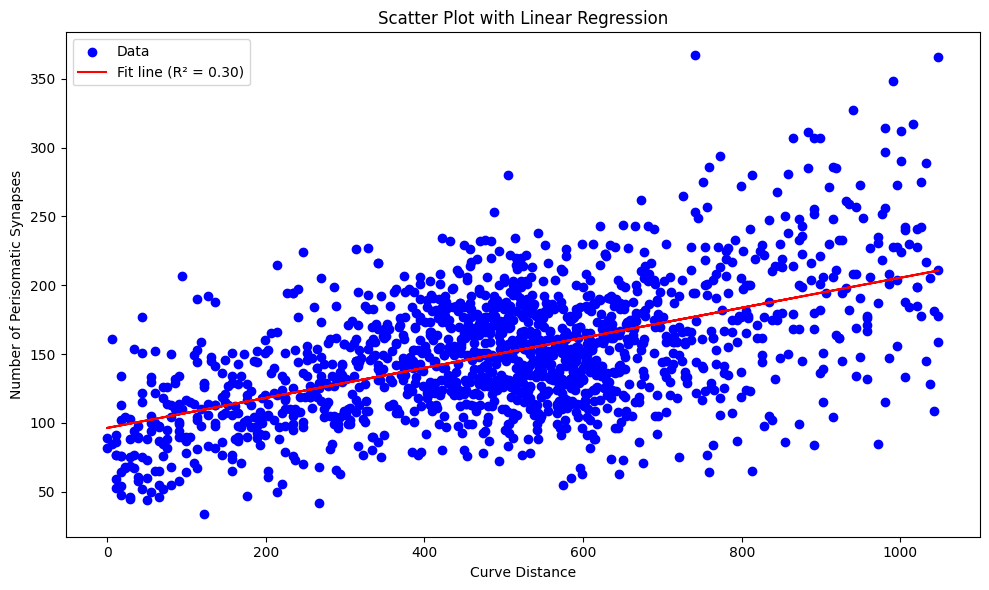

Linear Regression (Pearson) Results:
  Pearson correlation coefficient: 0.54
  R-squared: 0.30
  P-value: 0.000000000000000000000000000000

Spearman's Rank Correlation Results:
  Spearman correlation coefficient: 0.47
  Spearman P-value: 0.000000000000000000000000000000


In [171]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

df = merged_df

# Drop rows with missing values in either column
df = df.dropna(subset=['curve_distance', 'num_perisomatic_syn'])
df = df[df['num_perisomatic_syn'] != 0]

# 1. Scatter plot of the data
plt.figure(figsize=(10, 6))
plt.scatter(df['curve_distance'], df['num_perisomatic_syn'], color='blue', label='Data')

# 2. Perform linear regression using SciPy's linregress
slope, intercept, r_value, p_value, std_err = stats.linregress(df['curve_distance'], df['num_perisomatic_syn'])
# Generate the regression line
regression_line = slope * df['curve_distance'] + intercept

# Plot the regression line
plt.plot(df['curve_distance'], regression_line, color='red',
         label=f'Fit line (R² = {r_value**2:.2f})')

# 3. Add labels and title
plt.xlabel('Curve Distance')
plt.ylabel('Number of Perisomatic Synapses')
plt.title('Scatter Plot with Linear Regression')
plt.legend()
plt.tight_layout()

plt.savefig('Perisomatic_Synapse_Counts_Scatter_Plot_with_Linear_Regression.png', dpi=600)
plt.show()

# 4. Print the correlation and regression statistics
print("Linear Regression (Pearson) Results:")
print(f"  Pearson correlation coefficient: {r_value:.2f}")
print(f"  R-squared: {r_value**2:.2f}")
print(f"  P-value: {p_value:.30f}")

# 5. Additionally, compute Spearman's rank correlation (non-parametric)
spearman_corr, spearman_p = stats.spearmanr(df['curve_distance'], df['num_perisomatic_syn'])
print("\nSpearman's Rank Correlation Results:")
print(f"  Spearman correlation coefficient: {spearman_corr:.2f}")
print(f"  Spearman P-value: {spearman_p:.30f}")



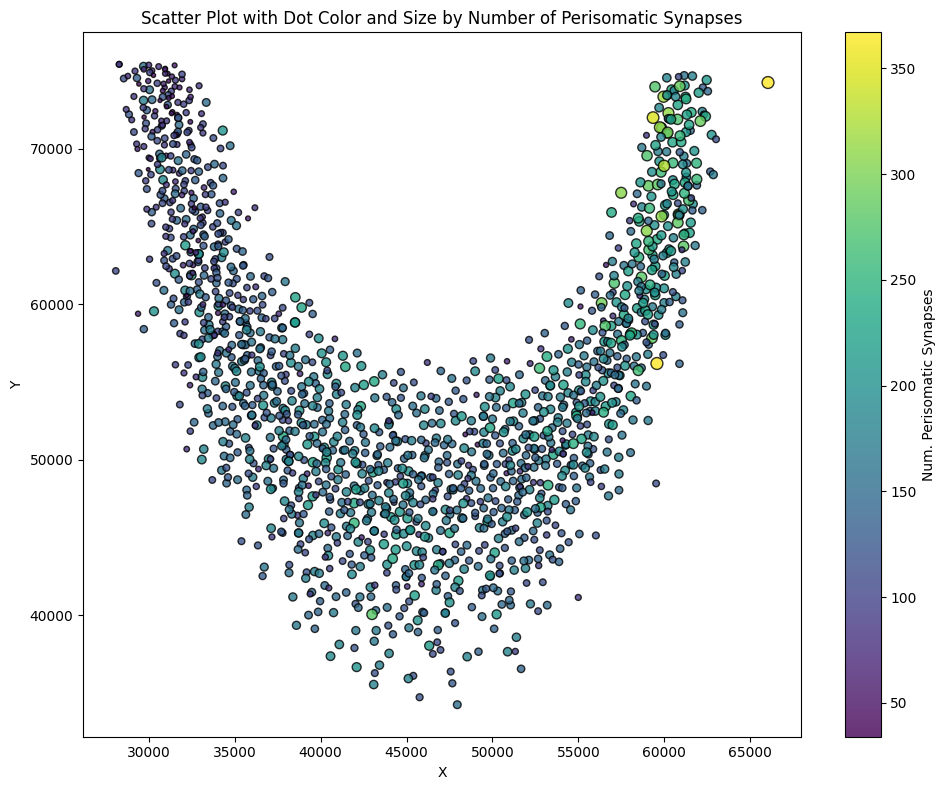

In [172]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


df = df.dropna(subset=['x', 'y', 'num_perisomatic_syn'])

plt.figure(figsize=(10, 8))

# Scale marker size by spines_per_micron; adjust the factor as needed.
size_scale = 0.2

scatter = plt.scatter(
    df['x'],
    df['y'],
    c=df['num_perisomatic_syn'],         # Color mapped to spines_per_micron
    cmap='viridis',                    # You can choose other colormaps if desired
    s=df['num_perisomatic_syn'] * size_scale,  # Size scaled by spines_per_micron
    alpha=0.8,
    edgecolor='black'                  # Optionally add edge for better visibility
)

# Add a colorbar to display the scale of spines_per_micron
cbar = plt.colorbar(scatter)
cbar.set_label('Num. Perisomatic Synapses')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter Plot with Dot Color and Size by Number of Perisomatic Synapses')
plt.tight_layout()

plt.savefig('Perisomatic_Synapse_Counts_Scatter_Plot_Locations.png', dpi=600)
plt.show()